In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from gmm_dataset import *
from util_hmm_variational_gibbs import *
from util_plots import *
from scipy.stats import invwishart, dirichlet
from torch.distributions.dirichlet import Dirichlet
sys.path.append('/home/hao/Research/probtorch/')
from probtorch.util import expand_inputs
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [2]:
T = 100
K = 3
D = 2
num_particles_rws = 20
mcmc_steps = 1
num_particles_smc = 20
NUM_HIDDEN = 256
NUM_LATENTS = K*K
NUM_OBS = T * K
# training parameters
NUM_SAMPLES = 1
# BATCH_SIZE = 100
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
CUDA = False

RESTORE = False

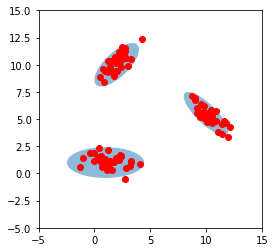

In [3]:
Xs, mu_true, cov_true, Zs_true, Pi_true, A_true = sampling_hmm(T, K, D)
plot_samples(Xs.data.numpy(), mu_true.data.numpy(), cov_true.data.numpy())
Y = Xs

In [4]:
## return samples in order to compute the weights and 
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, num_particles=1):
        A_samples = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        latents_dirs = torch.exp(self.latent_dir(hidden).view(K, K))
        for k in range(K):
            A_samples[k] = Dirichlet(latents_dirs[k]).sample()
        return latents_dirs, A_samples

In [5]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer

alpha_init_0, alpha_trans_0, m_0, beta_0, nu_0, W_0 = pirors(Y, T, D, K)
enc, optimizer = initialize()
## initialization
cov_ks = torch.zeros((K, D, D))
mu_ks = torch.zeros((K, D))
for k in range(K):
## sample mu_k and Sigma_k randomly
    cov_ks[k] = torch.from_numpy(invwishart.rvs(df=nu_0, scale=W_0.data.numpy())).float()
    mu_ks[k] = MultivariateNormal(loc=m_0, covariance_matrix=cov_ks[k] / beta_0).sample()
Pi = Dirichlet(alpha_init_0).sample()
A_samples = initial_trans(alpha_trans_0, K)

In [6]:
KLs = []
KL_ests = []
log_p_conds = []
log_qs = []
ESSs = []
# Zs = torch.from_numpy(Zs_true).float()
# mu_ks = torch.from_numpy(mu_true).float()
# cov_ks = torch.from_numpy(cov_true).float()
# Pi = torch.from_numpy(Pi_true).float()
Pi = Pi_true
# A = A_true
mu_ks = mu_true
cov_ks = cov_true

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    log_weights_rws = torch.zeros(num_particles_rws)
    log_qs = torch.zeros(num_particles_rws)
    log_p_conds = torch.zeros(num_particles_rws)
    kl = 0.0
    for l in range(num_particles_rws):
        # sample a obs sequence
#         Y, mu_true, cov_true, Zs_true, Pi_true, A_true = sampling_hmm(T, K, D)
        # initialize A from prior
#         A_samples = initial_trans(alpha_trans_0, K)
        # SMC to generate a weighted sample set for local states
        Zs, log_weights, log_normalizer = smc_hmm(Pi, A_samples, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
        # draw a sample from the sample set 
        Z_ret = resampling_smc(Zs, log_weights)
        latents_dirs, A_samples_new = enc(Z_ret.contiguous().view(-1, T*K), 1)
        log_p_joint_curr = log_joint(alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, Z_ret, Pi, A_samples_new, mu_ks, cov_ks, Y, T, D, K).detach().item()

        
        log_p_cond = 0.0
        alpha_trans_hat = alpha_trans_0 + pairwise(Z_ret, T).sum(0)
        for k in range(K):
            log_p_cond += Dirichlet(alpha_trans_hat[k]).log_prob(A_samples_new[k])        
        kl += kl_dirichlets(alpha_trans_0, latents_dirs, Z_ret, T, K)
        log_p_conds[l] = log_p_cond   
        
        log_qs[l] = log_q_hmm(latents_dirs, A_samples_new, K)
        log_weights_rws[l] = log_p_joint_curr - log_q_hmm(latents_dirs, A_samples_new, K) + log_normalizer
    kl /= num_particles_rws
        
    log_weights_rws = (log_weights_rws - log_sum_exp(log_weights_rws)).detach()
    weights_rws = torch.exp(log_weights_rws)
    ess = (1. / (weights_rws ** 2 ).sum()).item()
    loss_infer = - torch.mul(weights_rws, log_qs).sum()
    kl_est = torch.mul(weights_rws, log_p_conds - log_qs).sum().detach().item()
    kl.backward()
    KLs.append(kl.item())
    KL_ests.append(kl_est)
    ESSs.append(ess)
    optimizer.step()
    
    latents_dirs, A_samples_new = enc(Z_ret.contiguous().view(-1, T*K), 1)
    A_samples = A_samples_new.detach()
    print('epoch : %d, KL : %f, kl_est : %f' % (epoch, kl, kl_est))

epoch : 0, KL : 6.873457, kl_est : -41.241280
epoch : 1, KL : 5.514750, kl_est : -16.138748
epoch : 2, KL : 5.835061, kl_est : -28.396441
epoch : 3, KL : 6.421424, kl_est : -44.522175
epoch : 4, KL : 6.790035, kl_est : 2.176093
epoch : 5, KL : 6.055960, kl_est : -22.129745
epoch : 6, KL : 5.411976, kl_est : -8.658558
epoch : 7, KL : 5.819531, kl_est : -27.713833
epoch : 8, KL : 8.603686, kl_est : -72.577133
epoch : 9, KL : 5.057967, kl_est : -12.713036
epoch : 10, KL : 4.339172, kl_est : -30.662373
epoch : 11, KL : 5.179748, kl_est : -27.412018
epoch : 12, KL : 4.782950, kl_est : -28.378807
epoch : 13, KL : 5.151168, kl_est : -9.073643
epoch : 14, KL : 4.155174, kl_est : -19.353561
epoch : 15, KL : 4.666768, kl_est : -35.107826
epoch : 16, KL : 4.154269, kl_est : -4.115952
epoch : 17, KL : 4.589738, kl_est : -40.654060
epoch : 18, KL : 3.816935, kl_est : -2.427304
epoch : 19, KL : 4.176006, kl_est : -7.263702


In [ ]:
plot_kl_est(np.array(KLs), np.array(KL_ests))

In [ ]:
learned_dicichlet_post = latents_dirs
true_dirichlet_post = alpha_trans_0 + pairwise(Z_ret, T).sum(0)
print('variational : ')
print(learned_dicichlet_post)
print('conjugate posterior :')
print(true_dirichlet_post)

In [ ]:
plt.plot(np.array(ESSs) / num_particles_rws)

In [ ]:
from torch.distributions.categorical import Categorical
Categorical(torch.Tensor([1/2, 1/2])).sample()

In [ ]:
a = torch.Tensor([1,2,3,4,5])

In [ ]:
cov_true

In [ ]:
cov_ks